In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy
import scipy
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import os
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
#

#data_file_name = 'data/sacct_serc_20200622.out'
#data_file_name = 'data/sacct_serc_20200724.pkl'

In [3]:
# load_pickle=True
# pkl_name = "{}.pkl".format(os.path.splitext(data_file_name)[0])
# #
# if load_pickle:
#     with open(pkl_name, 'rb') as fin:
#         sacct_mazama=pickle.load(fin)
#     #
# else:
#     sacct_mazama = hpc_lib.SACCT_data_handler(data_file_name=data_file_name)
#     #
    
#     with open(pkl_name, 'wb') as fout:
#             #out_pkl = pickle.dump(sacct_demo.jobs_summary, fout)
#             out_pkl = pickle.dump(sacct_mazama, fout)

In [6]:
# n_cpus:
n_cpus = 1
if 'SLURM_JOB_ID' in os.environ.keys():
    # running in SLURM...
    if 'SLURM_JOB_CPUS_PER_NODE' in os.environ.keys():
        n_cpus = os.environ['SLURM_JOB_CPUS_PER_NODE']
    else:
        n_cpus = 1
else:
    n_cpus = min(8, mpp.cpu_count())
#
# or specify here:
# n_cpus = 8
#
print('** n_cpus: ', n_cpus)

** n_cpus:  1


In [8]:
end_dtm = dtm.datetime.now()+dtm.timedelta(days=1)
sacct_h5_file = f'sacct_data/serc_sacct_{end_dtm.year:04}{end_dtm.month:02}{end_dtm.day:02}.h5'
start_date = '2021-04-15'
#end_date   = '2021-05-15'
end_date = f'{end_dtm.year:04}-{end_dtm.month:02}-{end_dtm.day:02}'
print('*** dates: {} - {}'.format(start_date, end_date))
# NOTE: additional options can be passed in the more_options=[] arrary, or just as sacct_{option-name}={val}
#
if os.path.isfile(sacct_h5_file):
    SACCT_obj = hpc_lib.SACCT_data_from_h5(sacct_h5_file, keep_raw_data=False, n_cpu=n_cpus)
else:
    SACCT_obj = hpc_lib.SACCT_data_direct(group=None, partition='serc', start_date=start_date, n_cpu=n_cpus,
                                          end_date=end_date, keep_raw_data=False)
    #
#
print('** ', SACCT_obj.jobs_summary.dtype.names)

*** dates: 2021-04-15 - 2021-06-04
*** DEBUG: Now execute load_sacct_data()


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:496: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "process_row" failed type inference due to: non-precise type pyobject
During: typing of argument at /scratch/users/myoder96/HPC_analytics/hpc_lib.py (502)

File "hpc_lib.py", line 502:
    def process_row(self, rw, headers=None, RH=None):
        <source elided>
        #
        headers = (headers or self.headers)
        ^

  @numba.jit
/oak/stanford/schools/ees/share/cees/software/anaconda/3.8.5/lib/python3.8/site-packages/numba/core/object_mode_passes.py:177: NumbaWarning: Function "process_row" was compiled in object mode without forceobj=True.

File "hpc_lib.py", line 497:
    @numba.jit
    def process_row(self, rw, headers=None, RH=None):
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/oak/stanford/schools/ees/share/cees/software/anaconda/3.8.5/lib/python3.8/site-packages/numba/core/object_mode_passes.py:187: NumbaDeprec

*** DEBUG: load_sacct_data() executed. Compute calc_jobs_summary()


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:2534: RuntimeWarning: All-NaN slice encountered
  numpy.nanmax(sub_data['NTasks']).astype(int)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:2530: RuntimeWarning: All-NaN slice encountered
  jobs_summary[['End', 'Start', 'NCPUS', 'NNodes', 'NTasks']][k] = numpy.nanmax(sub_data['End']),\


**  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'JobID_parent')


In [9]:

print(f'** {sacct_h5_file}')

SACCT_obj.write_hdf5(sacct_h5_file)


** sacct_data/serc_sacct_20210604.h5
*** DEBUG: updating column [index], type=<i8
*** DEBUG: updating column [User], type=('|S8', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [Group], type=('|S8', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [GID], type=('|S6', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [JobName], type=('|S41', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [JobID], type=('|S16', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [JobIDRaw], type=('|S8', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [Partition], type=('|S4', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [State], type=('|S19', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [Timelimit], type=<f8
*** DEBUG: updating column [NCPUS], type=<i8
*** DEBUG: updating column [NNodes], type=<i8
*** DEBUG: updating column [Submit], type=<f8
*** DEBUG: updating column [Eligible], type=<f8
*** DEBUG: updating column [Start], type=<f8
*** DEBUG: upd

In [10]:
max_submit, max_start = [mpd.num2date(numpy.nanmax(SACCT_obj.jobs_summary[cl])) for cl in ['Start', 'Submit'] ]
print('*** max_submit: {}, max_start: {}'.format(*[mpd.num2date(numpy.nanmax(SACCT_obj.jobs_summary[cl]))
                                                   for cl in ['Start', 'Submit'] ]))
print('** cols: ', SACCT_obj.jobs_summary.dtype.names)

*** max_submit: 2021-06-03 07:04:42+00:00, max_start: 2021-06-03 07:04:37+00:00
** cols:  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'JobID_parent')


In [11]:
# NOTE: add this to the __init__. would be nice to refactor the code a bit to better handle inheritance.
if not 'chunk_size' in SACCT_obj.__dict__.keys():
    print('*** assigning chunk_size: ', chunk_size)
    SACCT_obj.chunk_size=1000

In [12]:
#
cpu_usage = SACCT_obj.active_jobs_cpu()
#
bin_size=7
cpu_weekly = SACCT_obj.active_jobs_cpu(bin_size=bin_size, t_min=None)

<ipython-input-13-2e573529bc8b>:2: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('211')
<ipython-input-13-2e573529bc8b>:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('212', sharex=ax1)
<ipython-input-13-2e573529bc8b>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(lbls)


[Text(18720.0, 0, '2021-4-3'),
 Text(18730.0, 0, '2021-4-13'),
 Text(18740.0, 0, '2021-4-23'),
 Text(18750.0, 0, '2021-5-3'),
 Text(18760.0, 0, '2021-5-13'),
 Text(18770.0, 0, '2021-5-23'),
 Text(18780.0, 0, '2021-6-2'),
 Text(18790.0, 0, '2021-6-12')]

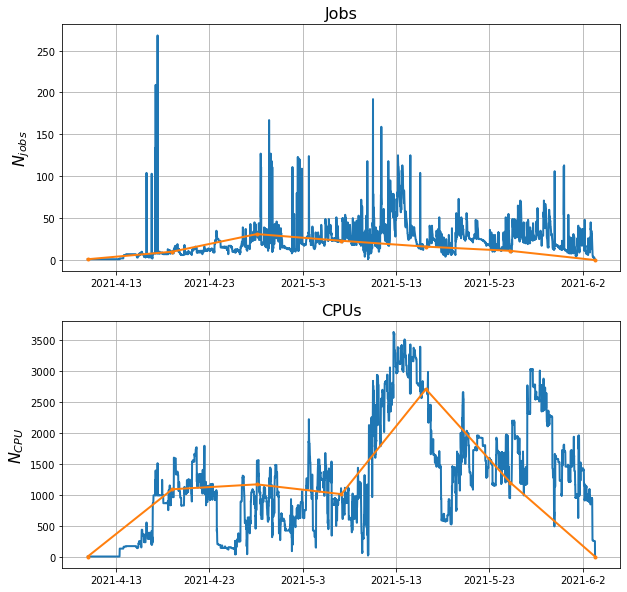

In [13]:
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_usage['time'], cpu_usage['N_jobs'], ls='-', lw=2., marker='')
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='.')
#
ax2.plot(cpu_usage['time'], cpu_usage['N_cpu'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='.')
#

ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax2.set_xticklabels(lbls)



In [14]:
# def time_bin_aggregates(XY, bin_mod=24, qs=[.25, .5, .74]):
#     XY=numpy.array(XY)
#     if XY.shape[0]==2:
#         X = XY[0,:]
#         Y = XY[1:]
#     else:
#         X = XY[:,0]
#         Y = XY[:,1]
#     #
#     #X_mod = ((X*bin_mod)%bin_mod).astype(int)
#     X_mod = ((X%1.)*bin_mod).astype(int)
#     #
#     stats_output=[]
#     for x in numpy.unique(X_mod):
#         ix = X_mod==x
#         this_Y = Y[ix]
#         stats_output += [numpy.append([x, numpy.mean(this_Y), numpy.std(this_Y)],
#                                       numpy.quantile(this_Y, qs))]
#     #
#     return numpy.core.records.fromarrays(numpy.array(stats_output).T, dtype=[('x', '>f8'), ('mean', '>f8'),
#                                                         ('stdev', '>f8')] + 
#                                          [('q_{}'.format(q), '>f8') for q in qs])
# #

    

<ipython-input-15-70aae9fac9e3>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('121')
<ipython-input-15-70aae9fac9e3>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('122')


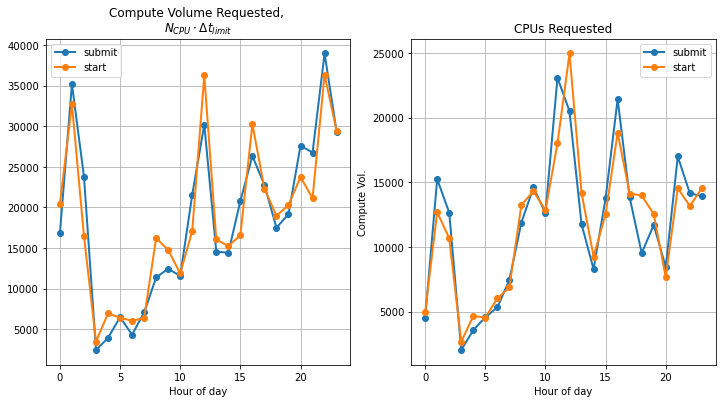

In [15]:
qs = [.5, .75, .95]
#
comp_vol_submit = SACCT_obj.get_submit_compute_vol_timeofday(qs=qs)
comp_vol_start = SACCT_obj.get_submit_compute_vol_timeofday(time_col='Start', qs=qs)
#
fg = plt.figure(figsize=(12,6))
ax1 = fg.add_subplot('121')
ax2 = fg.add_subplot('122')
ax1.grid()
ax2.grid()
#

# N = numpy.sum(comp_vol_submit['cpu-time'])
N = 1.
ax1.plot(comp_vol_submit['time'], comp_vol_submit['cpu-time']/N,
         ls='-', marker='o', lw=2., label='submit')
#print('*** ', numpy.sum(comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time'])))
#
# N = numpy.sum(comp_vol_start['cpu-time'])
N = 1 
ax1.plot(comp_vol_start['time'], comp_vol_start['cpu-time']/N,
         ls='-', marker='o', lw=2., label='start')
#print('*** ', numpy.sum(comp_vol_start['cpu-time']/N))
#
#N=numpy.sum(comp_vol_submit['cpus'])
N=1.
ax2.plot(comp_vol_submit['time'], comp_vol_submit['cpus']/N, ls='-', marker='o', lw=2., label='submit')

#N=numpy.sum(comp_vol_start['cpus'])
N=1
ax2.plot(comp_vol_start['time'], comp_vol_start['cpus']/N, ls='-', marker='o', lw=2., label='start')
#
#for k,cl in enumerate(comp_vol_tod.dtype.names[2:]):
#    ax1.plot(comp_vol_tod['time'], comp_vol_tod[cl], ls='-', marker='o', lw=2., label='$q={}$'.format(qs[k]))
#    break
#
ax1.legend(loc=0, numpoints=1)
ax1.set_title('Compute Volume Requested, \n$N_{CPU} \cdot \Delta t_{limit}$')
ax1.set_xlabel('Hour of day')
ax2.set_ylabel('Compute Vol.')

ax2.set_title('CPUs Requested')
ax2.set_xlabel('Hour of day')
ax2.legend(loc=1, numpoints=1)

Text(0.5, 0.98, 'Instantaneous Usage')

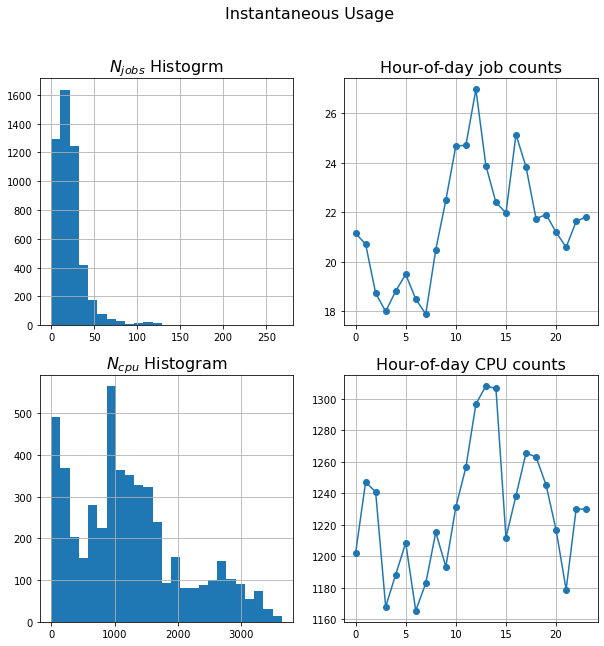

In [16]:
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
axs = [ax1, ax2, ax3, ax4]
[ax.grid() for ax in axs]
#
cpu_hourly = hpc_lib.time_bin_aggregates(XY=numpy.array([cpu_usage['time'], cpu_usage['N_cpu']]).T)
jobs_hourly = hpc_lib.time_bin_aggregates(XY=numpy.array([cpu_usage['time'], cpu_usage['N_jobs']]).T)

hh1 = ax1.hist(sorted(cpu_usage['N_jobs'])[0:int(1.0*len(cpu_usage))], bins=25, cumulative=False)
ax2.plot(jobs_hourly['x'], jobs_hourly['mean'], ls='-', marker='o')

hh3 = ax3.hist(cpu_usage['N_cpu'], bins=25)
ax4.plot(cpu_hourly['x'], cpu_hourly['mean'], ls='-', marker='o')

#ax1.set_ylim(-5., 200)
ax1.set_title('$N_{jobs}$ Histogrm', size=16)
ax2.set_title('Hour-of-day job counts', size=16)
ax3.set_title('$N_{cpu}$ Histogram', size=16)
ax4.set_title('Hour-of-day CPU counts', size=16)
#
plt.suptitle('Instantaneous Usage', size=16)

In [17]:
weekly_hours = SACCT_obj.get_cpu_hours(bin_size=7, n_points=5000)

daily_hours = SACCT_obj.get_cpu_hours(bin_size=1, n_points=5000)

<ipython-input-18-52a67d9dfeba>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(lbls)


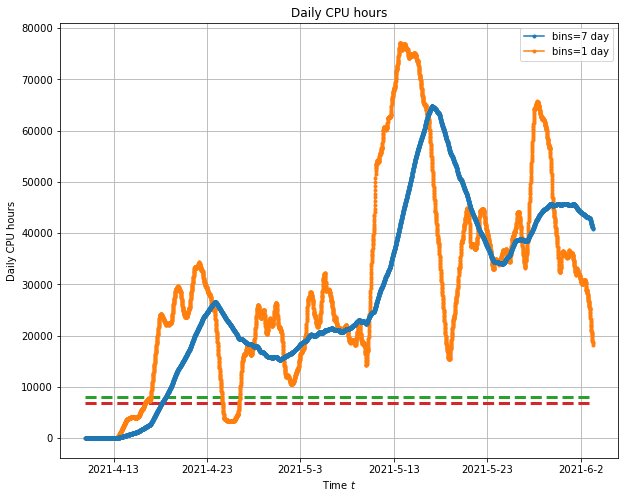

In [18]:
fg = plt.figure(figsize=(10,8))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(weekly_hours['time'], weekly_hours['cpu_hours']/7., ls='-', marker='.', label='bins=7 day', zorder=11)
ax1.plot(daily_hours['time'], daily_hours['cpu_hours'], ls='-', marker='.', label='bins=1 day', zorder=5)
#
ax1.plot( daily_hours['time'][0::(len(daily_hours['time'])-1)], numpy.ones(2)*14*24*24, ls='--', lw=3.)
ax1.plot( daily_hours['time'][0::(len(daily_hours['time'])-1)], numpy.ones(2)*12*24*24, ls='--', lw=3.)



#
fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax1.set_xticklabels(lbls)
ax1.set_xlabel('Time $t$')
ax1.set_ylabel('Daily CPU hours')
ax1.set_title('Daily CPU hours')
#
ax1.legend(loc=0)

In [19]:
print('** dtype:\n', SACCT_obj.jobs_summary.dtype)
#
#user_cols  = ['Timelimit', 'NCPUS', 'NNodes', 'TotalCPU','NTasks']
#user_types = ['>f8', '>i8', '>i8', '>f8', '>i8', '>f8']

user_cols = ['NCPUS', 'NNodes', 'Elapsed', 'Comp_Vol']
user_types = ['>i8', '>i8', '>f8', '>f8']
#
user_aggs = numpy.zeros( shape=[len(numpy.unique(SACCT_obj.jobs_summary['User'])),],
                        dtype={'names':user_cols, 'formats':user_types })
#
ix = {usr:numpy.where(SACCT_obj.jobs_summary['User']==usr)[0] 
      for usr in numpy.unique(SACCT_obj.jobs_summary['User'])}
#

** dtype:
 (numpy.record, [('index', '<i8'), ('User', 'O'), ('Group', 'O'), ('GID', 'O'), ('JobName', 'O'), ('JobID', 'O'), ('JobIDRaw', 'O'), ('Partition', 'O'), ('State', 'O'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', '<f8'), ('UserCPU', '<f8'), ('TotalCPU', '<f8'), ('NTasks', '<f8'), ('CPUTimeRAW', 'O'), ('Suspended', 'O'), ('ReqTRES', 'O'), ('AllocTRES', 'O'), ('JobID_parent', 'O')])


In [20]:
print('*** ', user_aggs.shape, user_aggs.dtype)
print('*** ', user_cols)
user_names = numpy.unique(SACCT_obj.jobs_summary['User'])
for k,user in enumerate(user_names):
    #print('** ', [numpy.sum(SACCT_obj.jobs_summary[cl][ix[user]]) for cl in user_cols])
    #
    vals = [numpy.sum( numpy.max([numpy.zeros(len(ix[user])), SACCT_obj.jobs_summary[cl][ix[user]]], axis=0) ) 
                      for cl in user_cols[:-1]]
    vals += [numpy.sum(SACCT_obj.jobs_summary['Elapsed'][ix[user]]*24. * SACCT_obj.jobs_summary['NCPUS'][ix[user]])]
    #print('** ix: ', ix[user])
    #vals = [numpy.sum( (SACCT_obj.jobs_summary[cl][ numpy.array(ix[user])] ) )
    #        for cl in user_cols]
    #print('** vals: ', vals)
    
    #user_aggs[user_cols][k] = tuple([numpy.sum(SACCT_obj.jobs_summary[cl][ix[user]]) for cl in user_cols])
    
    user_aggs[user_cols][k] = tuple( vals )
    #user_aggs[user_cols][k] = tuple(vals)



***  (39,) [('NCPUS', '>i8'), ('NNodes', '>i8'), ('Elapsed', '>f8'), ('Comp_Vol', '>f8')]
***  ['NCPUS', 'NNodes', 'Elapsed', 'Comp_Vol']


In [21]:
print('** user, {}'.format(user_cols ) )
for nm,rw in zip(user_names, user_aggs):
    print('** {}: {}, '.format(nm,rw))

** user, ['NCPUS', 'NNodes', 'Elapsed', 'Comp_Vol']
** aguilars: (9, 8, 18.97962963, 457.51361111), 
** agunn: (161, 161, 58.00231481, 1392.05555556), 
** aitous: (1089, 20, 15.07979167, 32578.37138889), 
** andea98: (8, 5, 0.10556713, 3.32055556), 
** arustam: (1, 1, 0., 0.), 
** asarhadi: (15031, 1765, 24.26177083, 4847.04666667), 
** axelwang: (384, 16, 10.33402778, 5952.4), 
** bmullet: (1633, 118, 196.59236111, 69655.28472222), 
** chwang01: (492, 10, 0.35439815, 611.04805556), 
** fantine: (88, 7, 0.07638889, 26.69111111), 
** gbarnier: (1744, 55, 3.86549769, 2829.54888889), 
** gvonwald: (32162, 257, 71.0784838, 213759.00444444), 
** haofu: (345, 27, 0.61221065, 1218.29166667), 
** hhampson: (464, 30, 7.15222222, 3768.84666667), 
** hilditch: (346, 48, 9.56719907, 3517.57833333), 
** hilley: (590, 39, 2.05877315, 934.97611111), 
** jaewooan: (40, 5, 0.00211806, 0.40666667), 
** jessssli: (1745, 73, 21.38787037, 12201.35805556), 
** joseph29: (25410, 1010, 19.80461806, 323537.401

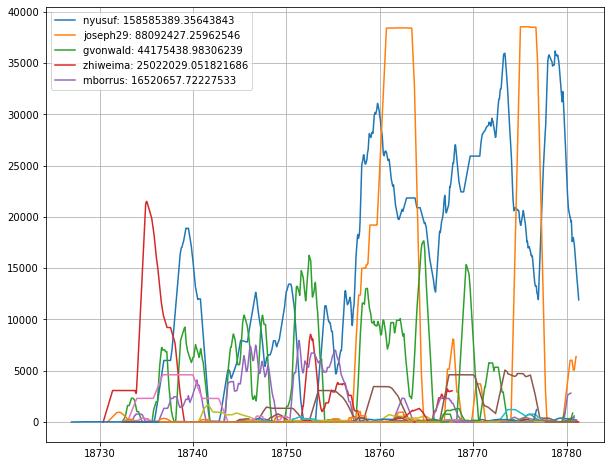

In [22]:
fg = plt.figure(figsize=(10,8))
ax = plt.gca()
ax.grid()
for k,usr in enumerate(user_names[numpy.argsort(user_aggs['Comp_Vol'])[::-1]]):
    cpuh = SACCT_obj.get_cpu_hours(bin_size=1.0, jobs_summary=SACCT_obj.jobs_summary[ix[usr]])
    ax.plot(cpuh['time'], cpuh['cpu_hours'], label=('{}: {}'.format(usr, numpy.sum(cpuh['cpu_hours']) )
                                                    if k<5 else None) )
ax.legend(loc=0)

<ipython-input-23-ba0d35d16ea0>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('121')
<ipython-input-23-ba0d35d16ea0>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('122')


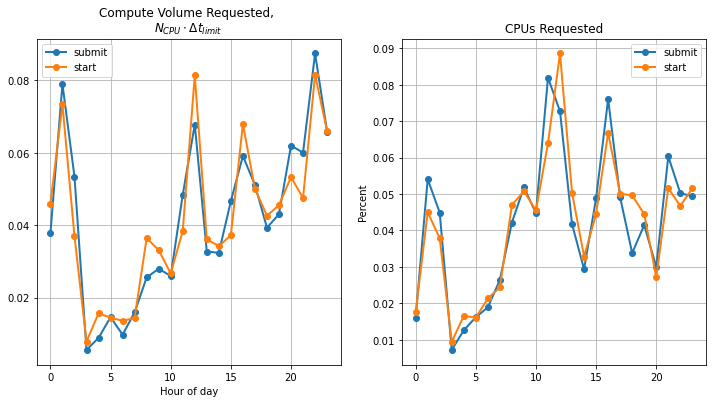

In [23]:
# time of day(-like) compute volume requests.

qs = [.5, .75, .95]
#
comp_vol_submit = SACCT_obj.get_submit_compute_vol_timeofday(qs=qs)
comp_vol_start = SACCT_obj.get_submit_compute_vol_timeofday(time_col='Start', qs=qs)
#
fg = plt.figure(figsize=(12,6))
ax1 = fg.add_subplot('121')
ax2 = fg.add_subplot('122')
ax1.grid()
ax2.grid()
#

ax1.plot(comp_vol_submit['time'], comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time']),
         ls='-', marker='o', lw=2., label='submit')
#print('*** ', numpy.sum(comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time'])))

ax1.plot(comp_vol_start['time'], comp_vol_start['cpu-time']/numpy.sum(comp_vol_start['cpu-time']),
         ls='-', marker='o', lw=2., label='start')
#print('*** ', numpy.sum(comp_vol_start['cpu-time']/numpy.sum(comp_vol_start['cpu-time'])))
#
ax2.plot(comp_vol_submit['time'], comp_vol_submit['cpus']/numpy.sum(comp_vol_submit['cpus']), ls='-', marker='o', lw=2., label='submit')
ax2.plot(comp_vol_start['time'], comp_vol_start['cpus']/numpy.sum(comp_vol_start['cpus']), ls='-', marker='o', lw=2., label='start')
#
#for k,cl in enumerate(comp_vol_tod.dtype.names[2:]):
#    ax1.plot(comp_vol_tod['time'], comp_vol_tod[cl], ls='-', marker='o', lw=2., label='$q={}$'.format(qs[k]))
#    break
#
ax1.legend(loc=0, numpoints=1)
ax1.set_title('Compute Volume Requested, \n$N_{CPU} \cdot \Delta t_{limit}$')
ax1.set_xlabel('Hour of day')
ax2.set_ylabel('Percent')

ax2.set_title('CPUs Requested')
ax2.legend(loc=1, numpoints=1)

#ax1.set_yscale('log')

***  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'JobID_parent')


Text(0.5, 1.0, '(Cumulative)')

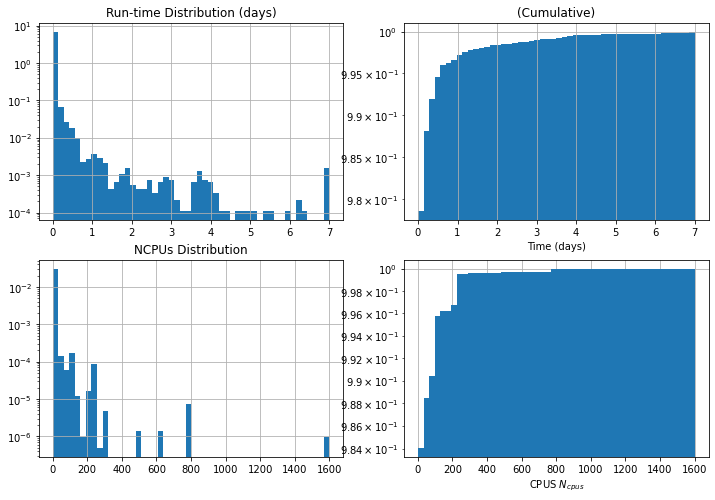

In [24]:
# compute some distributions:
print('*** ', SACCT_obj.jobs_summary.dtype.names)
run_times = SACCT_obj.get_run_times()

#
fg = plt.figure(figsize=(12,8))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
#ax1a.set_yscale('log')
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
#
hh = ax1.hist(run_times, bins=50, cumulative=False, density=True, log=True)
hh1c = ax2.hist(run_times, bins=50, cumulative=True, density=True, log=True, histtype='bar')
#hh1c = ax2.plot(sorted(run_times), numpy.array(numpy.linspace(1./len(run_times), 1.,
#                                                             len(run_times))), lw=3.0, zorder=11)
#
hh2 = ax3.hist(SACCT_obj.jobs_summary['NCPUS'], bins=50, density=True, log=True)
hh22 = ax4.hist(SACCT_obj.jobs_summary['NCPUS'], bins=50, density=True, log=True,
                 cumulative=True, histtype='bar', lw=3, zorder=11)
#hh22 = ax4.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True,
#                 cumulative=True, histtype='step', lw=3, zorder=11)
#ax1.plot(run_times, ls='', marker='.')
#print('*** ', run_times[0:20]*24, len(run_times), run_times.shape)
#
ax1.set_title('Run-time Distribution (days)')
ax3.set_title('NCPUs Distribution')
ax2.set_xlabel('Time (days)')
ax4.set_xlabel('CPUS $N_{cpus}$')
#
ax2.set_title("(Cumulative)")
#ax4.set_title("(Cumulative)")

#ax2.set_xlim(-1,800)

In [25]:
print('** ', len(run_times), len(SACCT_obj.jobs_summary['NCPUS']))

**  65606 65606


In [26]:
#ix_rt = numpy.argsort(run_times)
run_times_sorted = run_times.copy()
run_times_sorted.sort()
#
k_2 = numpy.searchsorted(run_times_sorted, 2.0)
k_7 = numpy.searchsorted(run_times_sorted, 7.0)
k_14 = numpy.searchsorted(run_times_sorted, 14.0)

#
# k_2 = numpy.searchsorted(run_times[ix_rt], 2.0)
# #k_7 = numpy.searchsorted(run_times[ix_rt], 7.0)
# k_7 = k_2 + numpy.searchsorted( (run_times[ix_rt])[k_2:], 7.0)
# k_14 = k_7 + numpy.searchsorted( (run_times[ix_rt])[k_7:], 14.0)
#
N=float(len(run_times))
print('*** quantiles for t=2,7,14 days: {}, {}, {}'.format(float(k_2)/N, k_7/N, k_14/N))
#
# percent of jobs that use N<24 cores (aka, can run on a single node). Note that these are especially
#. eligible for GCP.
N_24 = numpy.sum(SACCT_obj.jobs_summary['NCPUS']<25)
print('*** N_24/N={}'.format(N_24/N))


*** quantiles for t=2,7,14 days: 0.998353809102826, 0.9998018473920068, 1.0
*** N_24/N=0.9821510227723074


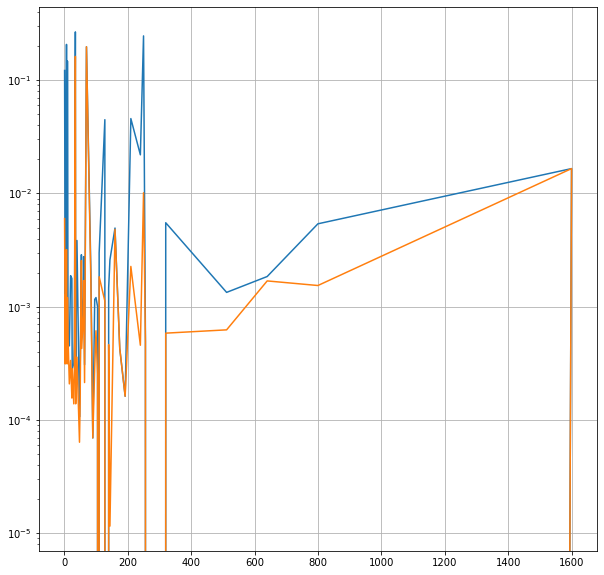

In [27]:
wait_stats = SACCT_obj.get_wait_stats()
#
fg = plt.figure(figsize=(10,10))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(wait_stats['ncpus'], wait_stats['mean'], ls='-', label='mean')
ax1.plot(wait_stats['ncpus'], wait_stats['median'], ls='-', label='median')
#
#ax1.set_ylim(-.1, .5)
ax1.set_yscale('log')

***  ['2019-10-31', '2020-2-8', '2020-5-18', '2020-8-26', '2020-12-4', '2021-3-14', '2021-6-22', '2021-9-30']


<ipython-input-28-ff8e6c5bdb1b>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('211')
<ipython-input-28-ff8e6c5bdb1b>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('212', sharex=ax1)
<ipython-input-28-ff8e6c5bdb1b>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(lbls)


Text(0.5, 0.98, 'Mazama Activity, $\\Delta t_{binsize}=7$ days')

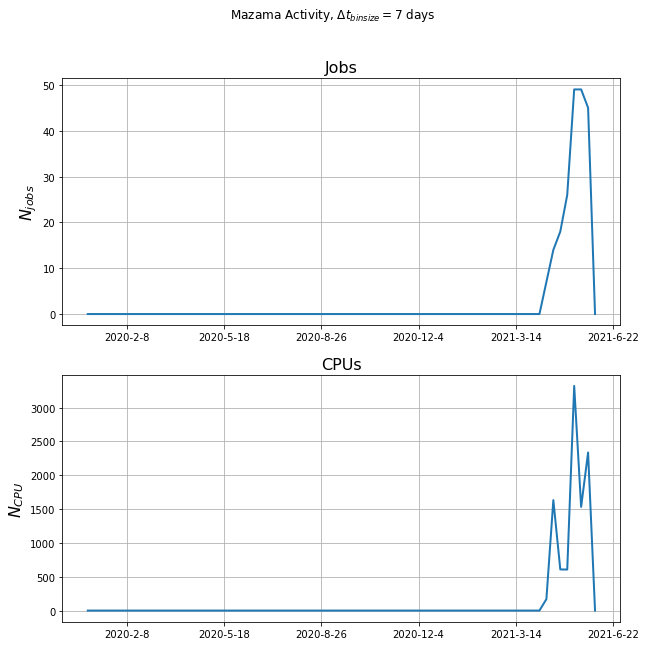

In [28]:
#t0 = mpd.date2num(dtm.datetime(2019,9,2, tzinfo=pytz.timezone('UTC')))
t0 = mpd.date2num(dtm.datetime(2019,12,30, tzinfo=pytz.timezone('UTC')))
#
bin_size=7
cpu_weekly = SACCT_obj.active_jobs_cpu(bin_size=bin_size, t_min=t0)
#
fg = plt.figure(figsize=(10,10))
plt.suptitle('Weekly Usage')
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='')

ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
print('*** ', lbls)
#
ax2.set_xticklabels(lbls)
#
plt.suptitle('Mazama Activity, $\Delta t_{{binsize}}={}$ days'.format(bin_size))


***  ['2019-10-31', '2020-2-8', '2020-5-18', '2020-8-26', '2020-12-4', '2021-3-14', '2021-6-22', '2021-9-30']


<ipython-input-29-977c250b8602>:30: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('211')
<ipython-input-29-977c250b8602>:31: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('212', sharex=ax1)
<ipython-input-29-977c250b8602>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(lbls)


[Text(18200.0, 0, '2019-10-31'),
 Text(18300.0, 0, '2020-2-8'),
 Text(18400.0, 0, '2020-5-18'),
 Text(18500.0, 0, '2020-8-26'),
 Text(18600.0, 0, '2020-12-4'),
 Text(18700.0, 0, '2021-3-14'),
 Text(18800.0, 0, '2021-6-22'),
 Text(18900.0, 0, '2021-9-30')]

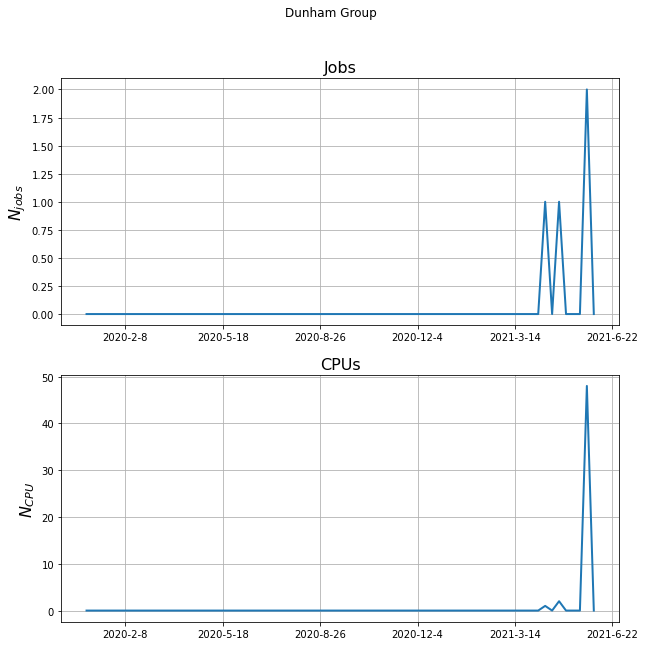

In [29]:
#t0 = mpd.date2num(dtm.datetime(2019,9,2, tzinfo=pytz.timezone('UTC')))
t0 = mpd.date2num(dtm.datetime(2019,12,30, tzinfo=pytz.timezone('UTC')))
#
# and get a list of users to construct an index:
# $ finger dunham
# Login: edunham         Name: Eric Dunham
# Directory: /home/edunham             Shell: /bin/bash
# Never logged in.
# No mail.
# No Plan.
# [rcwhite@cees-mgmt0 ~]$ id edunham
# uid=60367(edunham) gid=100(users) groups=100(users),203(tgp),70137(fs-erd)
# [rcwhite@cees-mgmt0 ~]$ getent group | grep tgp
# tgp:*:203:ooreilly,kashefi,malmq,axelwang,lwat054,glotto,chao2,bponemon,danmohad,sinux1,
# gnava,eliasrh,dennis,zhuwq,yyang85,sbydlon,houyun,cstierns,mrivet,jlmaurer,myoder96,sozawa,schu3,
# lbruhat,kallison,labraha2,kcoppess,edunham
#
users = 'ooreilly,kashefi,malmq,axelwang,lwat054,glotto,chao2,bponemon,danmohad,sinux1,\
gnava,eliasrh,dennis,zhuwq,yyang85,sbydlon,houyun,cstierns,mrivet,jlmaurer,myoder96,sozawa,\
schu3,lbruhat,kallison,labraha2,kcoppess,edunham'.split(',')
users = [s for s in users if not s in ('myoder96', 'dennis')]
#print('** users: ', users)
#
ix = numpy.array([s in users for s in SACCT_obj.jobs_summary['User'] ])
#print('** ', (sacct_mazama.jobs_summary[ix])[0:20] )
#
cpu_weekly = SACCT_obj.active_jobs_cpu(bin_size=7., t_min=t0, ix=ix)
#
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='')
#
plt.suptitle('Dunham Group')
ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
print('*** ', lbls)
#
ax2.set_xticklabels(lbls)

In [ ]:
# if True:
#     with open(data_file_name, 'r') as fin:
#         header_rw = fin.readline()
#         print('*** ', header_rw)

#     headers = header_rw.split('|')
#     k_group = headers.index('Group')
#     k_gid = headers.index('GID')
#     #
    
#     with open(data_file_name, 'r') as fin:
#         for k,rw in enumerate(fin):
#             #if 'dunham' in rw: print('** ', rw)
#             #if 'dunham' in rw:
#             #    rws = rw.split('|')
#             #    print('** ', rws[k_group], rws[k_gid])
#             if 'Partition_Limit' in rw:
#                 print('** ', rw)
#                 k+=1
#                 if k>10: break



In [ ]:
print('** ',SACCT_obj.jobs_summary.dtype.names)
print('** ', mpd.num2date(SACCT_obj.jobs_summary['Submit'][-1]))

In [ ]:
dta = SACCT_obj.jobs_summary.copy()
dta.sort(order='Submit')

## Drafts of some reports
- We have a couple reports already made. Let's start with those.
- Even for those reports, we'll want to modify the inputs, for example to specify all Earth users/groups, not juust look at the `serc` partition.


In [1]:
### Report(s)
#
# first, we need to make groups.
# groups who can access serc:
# (base) [myoder96@sh01-ln01 login ~]$ scontrol show partition serc | grep Allow
#   AllowGroups=sh_s-ees,sh_sysadm AllowAccounts=ALL AllowQos=normal,high_p,system
#
# so all permissions are consolidated to the sh_s-ees group
# to get users in a group:
# USERS=`getent passwd | awk -F: -v g=$(id -g $PI_SUNET) '$4==g {print $1}'`
#. but this does not seem to work for the sh_s-ees group
# we can use id to get secondary groups (we'll need to pares...), for example,
# $ (base) [myoder96@sh01-ln01 login ~/Codes/cees_scripts]$ id myoder96
# uid=362778(myoder96) gid=32264(ruthm) groups=99001(sh_users),98013(sh_sw-stata),98008(sh_sw-schrodinger),97002(sh_s-ees),97005(sh_s-hns),1007582(oak_p-cees-backup),1008811(oak_s-ees),32264(ruthm)
# this should do it:
# getent group sh_s-ees
# then maybe just parse in Python...

** oneillm, ['ipshi91', 'haofu', 'oneillm', 'shanni30', 'htang12', 'hsstern', 'yy2822', 'ipshi91', 'haofu', 'oneillm', 'shanni30', 'htang12', 'hsstern', 'yy2822']
** biondo, ['biondo', 'sfarris', 'joseph29', 'arustam', 'yinbin', 'gbarnier', 'minjun', 'fantine', 'clapp', 'biondo', 'sfarris', 'joseph29', 'arustam', 'yinbin', 'gbarnier', 'minjun', 'fantine', 'clapp']
** mukerji, ['mukerji', 'jiayuanh', 'spetrov', 'kanfar', 'josuesdf', 'mliu9', 'pradhan1', 'kashefi', 'ammilten', 'suihong', 'vdas2', 'mukerji', 'jiayuanh', 'spetrov', 'kanfar', 'josuesdf', 'mliu9', 'pradhan1', 'kashefi', 'ammilten', 'suihong', 'vdas2']
** gerritsn, ['gerritsn', 'dabh', 'gerritsn', 'dabh']
** robertj2, ['chwang01', 'sferon', 'leehi', 'efluet', 'agaspert', 'gmcnicol', 'robertj2', 'lydiav', 'saraknox', 'frankliu', 'ouyangzt', 'sjg79', 'chwang01', 'sferon', 'leehi', 'efluet', 'agaspert', 'gmcnicol', 'robertj2', 'lydiav', 'saraknox', 'frankliu', 'ouyangzt', 'sjg79']
** ruthm, ['rcwhite', 'myoder96', 'rcwhite', 'my

/scratch/users/myoder96/HPC_analytics/hpc_lib.py:496: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "process_row" failed type inference due to: non-precise type pyobject
During: typing of argument at /scratch/users/myoder96/HPC_analytics/hpc_lib.py (502)

File "hpc_lib.py", line 502:
    def process_row(self, rw, headers=None, RH=None):
        <source elided>
        #
        headers = (headers or self.headers)
        ^

  @numba.jit
/oak/stanford/schools/ees/share/cees/software/anaconda/3.8.5/lib/python3.8/site-packages/numba/core/object_mode_passes.py:177: NumbaWarning: Function "process_row" was compiled in object mode without forceobj=True.

File "hpc_lib.py", line 497:
    @numba.jit
    def process_row(self, rw, headers=None, RH=None):
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/oak/stanford/schools/ees/share/cees/software/anaconda/3.8.5/lib/python3.8/site-packages/numba/core/object_mode_passes.py:187: NumbaDeprec

/oak/stanford/schools/ees/share/cees/software/anaconda/3.8.5/lib/python3.8/site-packages/numba/core/object_mode_passes.py:177: NumbaWarning: Function "process_row" was compiled in object mode without forceobj=True.

File "hpc_lib.py", line 497:
    @numba.jit
    def process_row(self, rw, headers=None, RH=None):
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/oak/stanford/schools/ees/share/cees/software/anaconda/3.8.5/lib/python3.8/site-packages/numba/core/object_mode_passes.py:187: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "hpc_lib.py", line 497:
    @numba.jit
    def process_row(self, rw, headers=None, RH=None):
    ^

  warnings.warn(errors.NumbaDeprecationWarning(msg,


*** DEBUG: load_sacct_data() executed. Compute calc_jobs_summary()


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:2534: RuntimeWarning: All-NaN slice encountered
  numpy.nanmax(sub_data['NTasks']).astype(int)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:2534: RuntimeWarning: All-NaN slice encountered
  numpy.nanmax(sub_data['NTasks']).astype(int)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:2534: RuntimeWarning: All-NaN slice encountered
  numpy.nanmax(sub_data['NTasks']).astype(int)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:2530: RuntimeWarning: All-NaN slice encountered
  jobs_summary[['End', 'Start', 'NCPUS', 'NNodes', 'NTasks']][k] = numpy.nanmax(sub_data['End']),\
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:2531: RuntimeWarning: All-NaN slice encountered
  numpy.nanmin(sub_data['Start']),\
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:2534: RuntimeWarning: All-NaN slice encountered
  numpy.nanmax(sub_data['NTasks']).astype(int)


keys:  dict_keys(['oneillm', 'biondo', 'mukerji', 'gerritsn', 'robertj2', 'ruthm', 'jcaers', 'dekas', 'kcasciot', 'kmaher', 'sagraham', 'jsuckale', 'mburke', 'mlapotre', 'konings', 'beroza', 'gorelick', 'mavko', 'sklemp', 'rewing1', 'harrisgp', 'omramom', 'edunham', 'dustinms', 'lou', 'zoback', 'aditis2', 'jkw1', 'caf', 'segall', 'fendorf', 'sonori', 'horne', 'tchelepi', 'jlpayne', 'esper', 'leift', 'welander', 'abrandt', 'lkschaef', 'aleslieb', 'ibattiat', 'rknight', 'smbenson', 'cfield', 'hilley', 'wellswor', 'wmao', 'arrigo', 'glucia', 'drlowe', 'All'])
*** DEBUG: group: oneillm


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-in

*** [oneillm] Slide_1 added??:: 3


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1132: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax5 = fg.add_subplot('235', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1133: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax6 = fg.add_subplot('236', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1216: UserWarning: FixedFormatter should only be used together with FixedLocator
  tmp_x = ax.set_xticklabels(['', *[str(int((x%24)/daily_Period) ) for x in ax.get_xticks()[1:]]])


*** Slide_2 added??::  4
*** DEBUG: group: biondo


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [biondo] Slide_1 added??:: 5


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('232', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1130: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax3 = fg.add_subplot('233', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two mino

*** Slide_2 added??::  6
*** DEBUG: group: mukerji


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [mukerji] Slide_1 added??:: 7


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('232', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1130: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax3 = fg.add_subplot('233', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two mino

*** Slide_2 added??::  8
*** DEBUG: group: gerritsn
*** WARNING! group: gerritsn no records
*** DEBUG: group: robertj2


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [robertj2] Slide_1 added??:: 9


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('232', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1130: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax3 = fg.add_subplot('233', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two mino

*** Slide_2 added??::  10
*** DEBUG: group: ruthm


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [ruthm] Slide_1 added??:: 11


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('232', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1130: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax3 = fg.add_subplot('233', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two mino

*** Slide_2 added??::  12
*** DEBUG: group: jcaers


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [jcaers] Slide_1 added??:: 13


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('232', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1130: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax3 = fg.add_subplot('233', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two mino

*** Slide_2 added??::  14
*** DEBUG: group: dekas
*** WARNING! group: dekas no records
*** DEBUG: group: kcasciot
*** WARNING! group: kcasciot no records
*** DEBUG: group: kmaher
*** WARNING! group: kmaher no records
*** DEBUG: group: sagraham
*** WARNING! group: sagraham no records
*** DEBUG: group: jsuckale


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-in

*** [jsuckale] Slide_1 added??:: 15


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax4 = fg.add_subplot('234')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1132: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax5 = fg.add_subplot('235', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1133: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax6 = fg.add_subplot('236', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1216: UserWarning: FixedFormatter should only be used together with FixedLocator
  tmp_x = ax.set_xticklabels(['', *[str(int((x%24)/daily_Period) ) f

*** Slide_2 added??::  16
*** DEBUG: group: mburke


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [mburke] Slide_1 added??:: 17


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('232', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1130: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax3 = fg.add_subplot('233', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two mino

*** Slide_2 added??::  18
*** DEBUG: group: mlapotre


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [mlapotre] Slide_1 added??:: 19


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('232', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1130: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax3 = fg.add_subplot('233', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two mino

*** Slide_2 added??::  20
*** DEBUG: group: konings
*** WARNING! group: konings no records
*** DEBUG: group: beroza


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [beroza] Slide_1 added??:: 21


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('232', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1130: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax3 = fg.add_subplot('233', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two mino

*** Slide_2 added??::  22
*** DEBUG: group: gorelick
*** WARNING! group: gorelick no records
*** DEBUG: group: mavko
*** WARNING! group: mavko no records
*** DEBUG: group: sklemp
*** WARNING! group: sklemp no records
*** DEBUG: group: rewing1
*** WARNING! group: rewing1 no records
*** DEBUG: group: harrisgp
*** WARNING! group: harrisgp no records
*** DEBUG: group: omramom


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1780: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fg = plt.figure(figsize=fig_size)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xti

*** [omramom] Slide_1 added??:: 23


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('232', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1130: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax3 = fg.add_subplot('233', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two mino

*** Slide_2 added??::  24
*** DEBUG: group: edunham


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [edunham] Slide_1 added??:: 25


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('232', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1130: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax3 = fg.add_subplot('233', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two mino

*** Slide_2 added??::  26
*** DEBUG: group: dustinms


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-in

*** [dustinms] Slide_1 added??:: 27


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1133: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax6 = fg.add_subplot('236', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1216: UserWarning: FixedFormatter should only be used together with FixedLocator
  tmp_x = ax.set_xticklabels(['', *[str(int((x%24)/daily_Period) ) for x in ax.get_xticks()[1:]]])


*** Slide_2 added??::  28
*** DEBUG: group: lou


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [lou] Slide_1 added??:: 29


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('232', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1130: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax3 = fg.add_subplot('233', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two mino

*** Slide_2 added??::  30
*** DEBUG: group: zoback
*** WARNING! group: zoback no records
*** DEBUG: group: aditis2


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [aditis2] Slide_1 added??:: 31


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('232', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1130: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax3 = fg.add_subplot('233', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two mino

*** Slide_2 added??::  32
*** DEBUG: group: jkw1
*** WARNING! group: jkw1 no records
*** DEBUG: group: caf
*** WARNING! group: caf no records
*** DEBUG: group: segall


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [segall] Slide_1 added??:: 33


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('232', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1130: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax3 = fg.add_subplot('233', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two mino

*** Slide_2 added??::  34
*** DEBUG: group: fendorf
*** WARNING! group: fendorf no records
*** DEBUG: group: sonori
*** WARNING! group: sonori no records
*** DEBUG: group: horne
*** WARNING! group: horne no records
*** DEBUG: group: tchelepi


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [tchelepi] Slide_1 added??:: 35


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('232', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1130: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax3 = fg.add_subplot('233', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two mino

*** Slide_2 added??::  36
*** DEBUG: group: jlpayne
*** WARNING! group: jlpayne no records
*** DEBUG: group: esper
*** WARNING! group: esper no records
*** DEBUG: group: leift


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [leift] Slide_1 added??:: 37


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('232', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1130: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax3 = fg.add_subplot('233', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two mino

*** Slide_2 added??::  38
*** DEBUG: group: welander
*** WARNING! group: welander no records
*** DEBUG: group: abrandt


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [abrandt] Slide_1 added??:: 39


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('232', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1130: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax3 = fg.add_subplot('233', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two mino

*** Slide_2 added??::  40
*** DEBUG: group: lkschaef
*** WARNING! group: lkschaef no records
*** DEBUG: group: aleslieb
*** WARNING! group: aleslieb no records
*** DEBUG: group: ibattiat


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [ibattiat] Slide_1 added??:: 41


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('232', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1130: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax3 = fg.add_subplot('233', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two mino

*** Slide_2 added??::  42
*** DEBUG: group: rknight
*** WARNING! group: rknight no records
*** DEBUG: group: smbenson
*** WARNING! group: smbenson no records
*** DEBUG: group: cfield
*** WARNING! group: cfield no records
*** DEBUG: group: hilley


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [hilley] Slide_1 added??:: 43


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('232', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1130: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax3 = fg.add_subplot('233', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two mino

*** Slide_2 added??::  44
*** DEBUG: group: wellswor


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [wellswor] Slide_1 added??:: 45


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('232', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1130: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax3 = fg.add_subplot('233', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two mino

*** Slide_2 added??::  46
*** DEBUG: group: wmao
*** WARNING! group: wmao no records
*** DEBUG: group: arrigo
*** WARNING! group: arrigo no records
*** DEBUG: group: glucia
*** WARNING! group: glucia no records
*** DEBUG: group: drlowe
*** WARNING! group: drlowe no records
*** DEBUG: group: All


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1781: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1784: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1828: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [All] Slide_1 added??:: 47


/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1128: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('231')
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1129: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('232', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1130: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax3 = fg.add_subplot('233', projection=periodic_projection)
/scratch/users/myoder96/HPC_analytics/hpc_lib.py:1131: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two mino

*** Slide_2 added??::  48
** adding slide: slide_2
** adding slide: slide_3
** adding slide: slide_4
** adding slide: slide_5
** adding slide: slide_6
** adding slide: slide_7
** adding slide: slide_8
** adding slide: slide_9
** adding slide: slide_10
** adding slide: slide_11
** adding slide: slide_12
** adding slide: slide_13
** adding slide: slide_14
** adding slide: slide_15
** adding slide: slide_16
** adding slide: slide_17
** adding slide: slide_18
** adding slide: slide_19
** adding slide: slide_20
** adding slide: slide_21
** adding slide: slide_22
** adding slide: slide_23
** adding slide: slide_24
** adding slide: slide_25
** adding slide: slide_26
** adding slide: slide_27
** adding slide: slide_28
** adding slide: slide_29
** adding slide: slide_30
** adding slide: slide_31
** adding slide: slide_32
** adding slide: slide_33
** adding slide: slide_34
** adding slide: slide_35
** adding slide: slide_36
** adding slide: slide_37
** adding slide: slide_38
** adding slide: sli

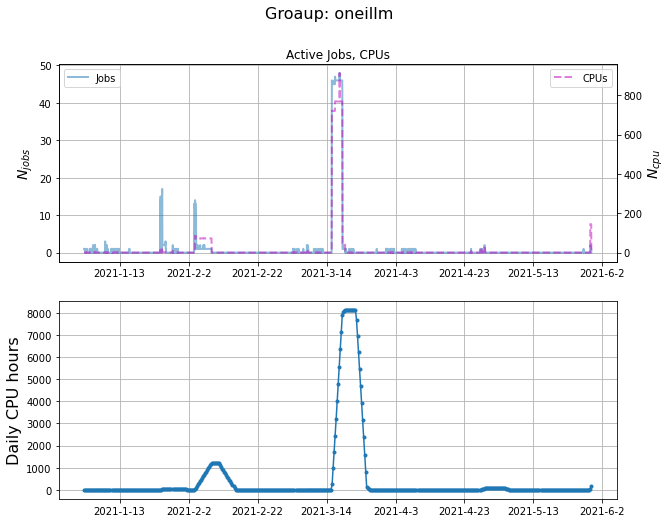

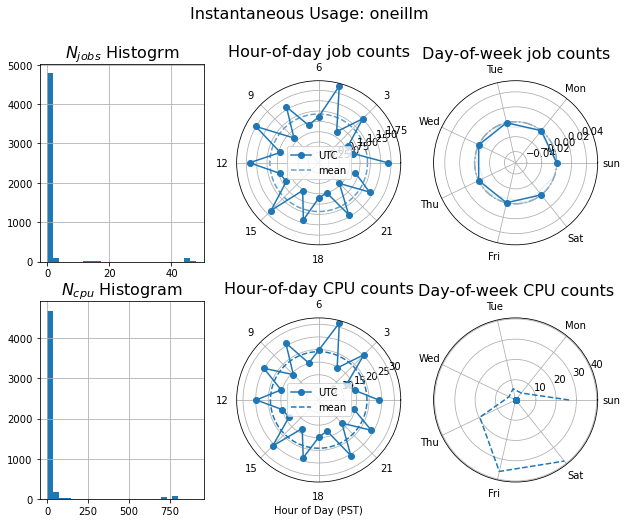

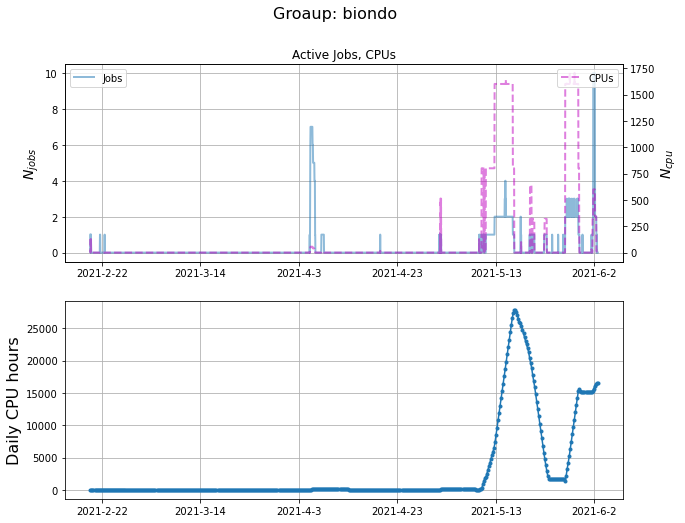

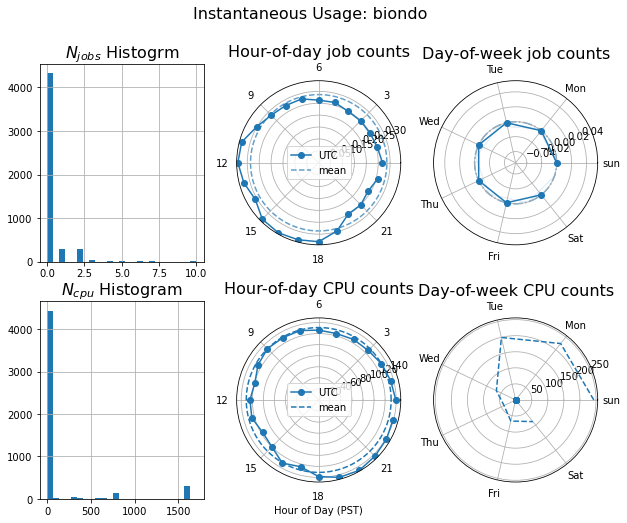

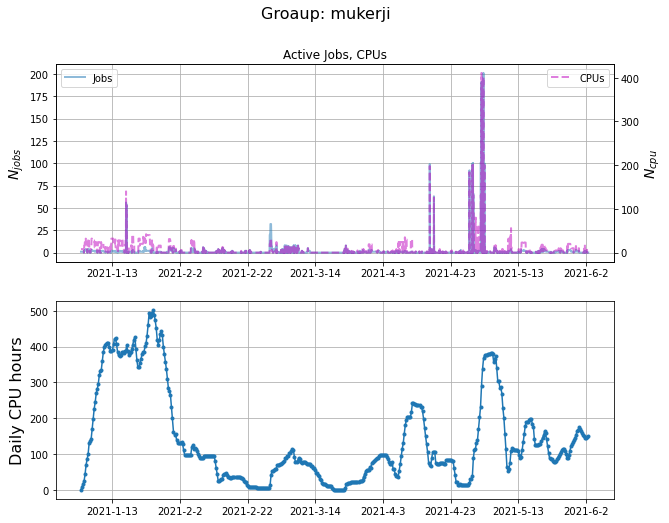

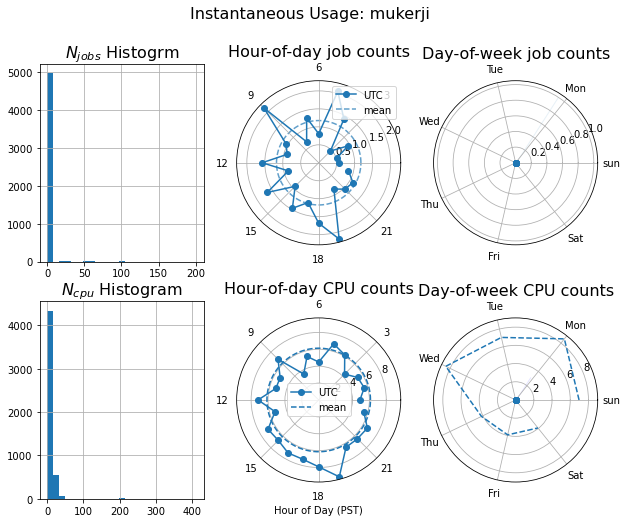

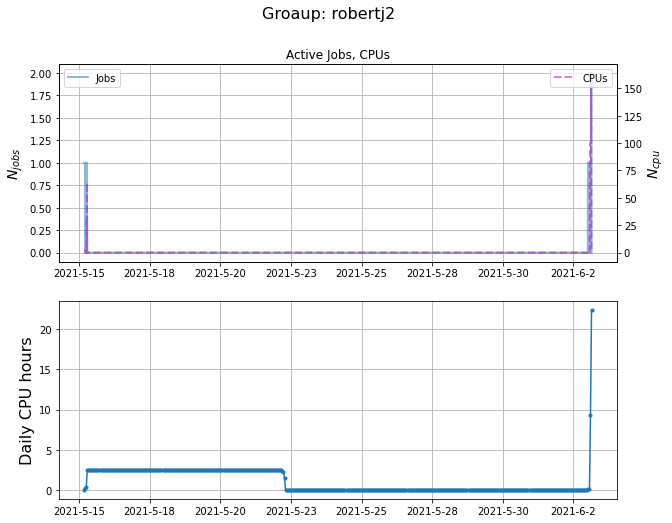

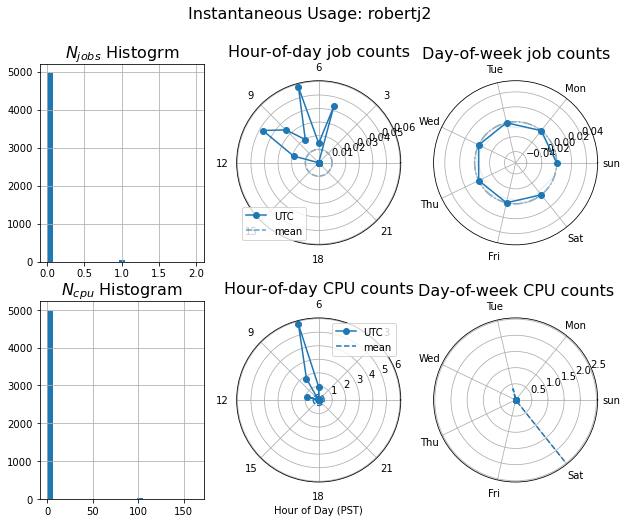

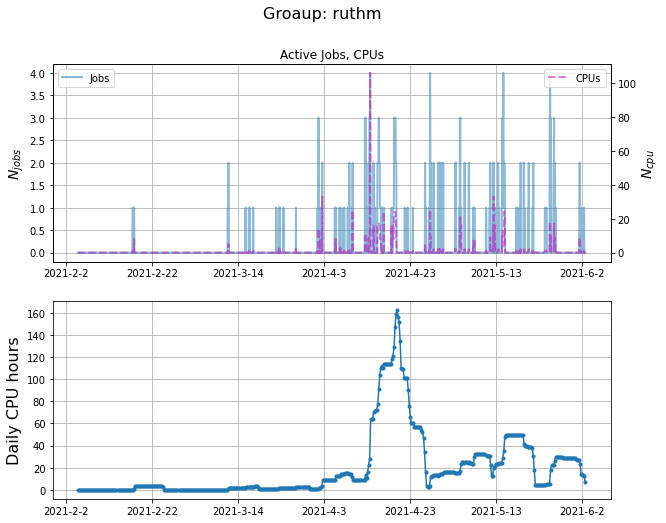

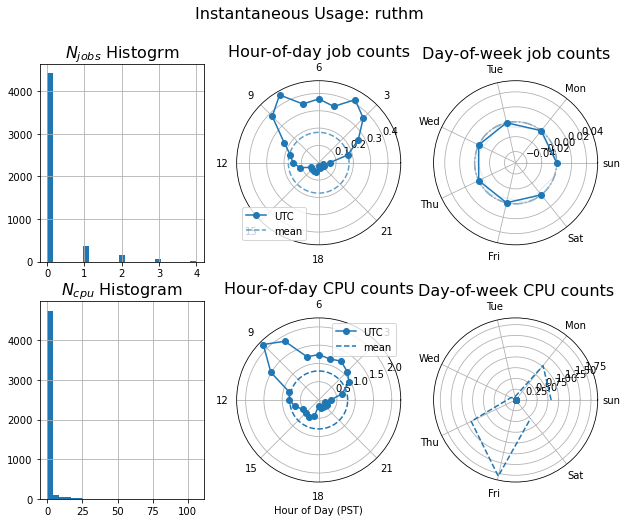

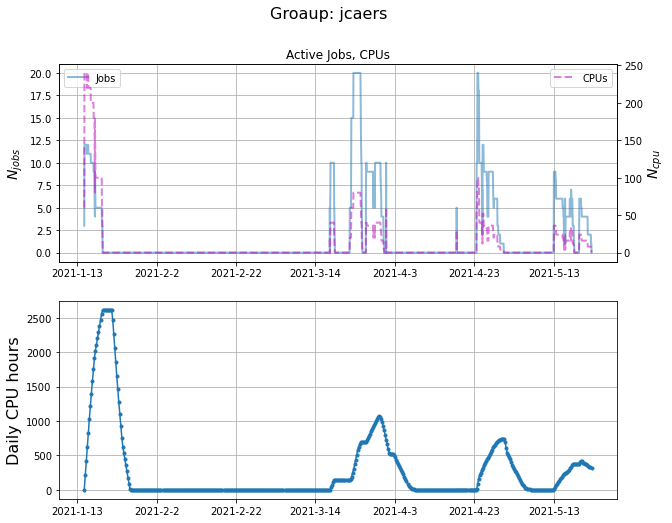

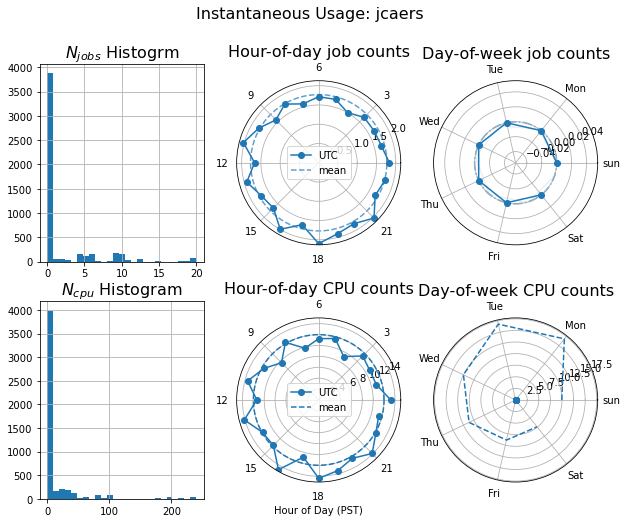

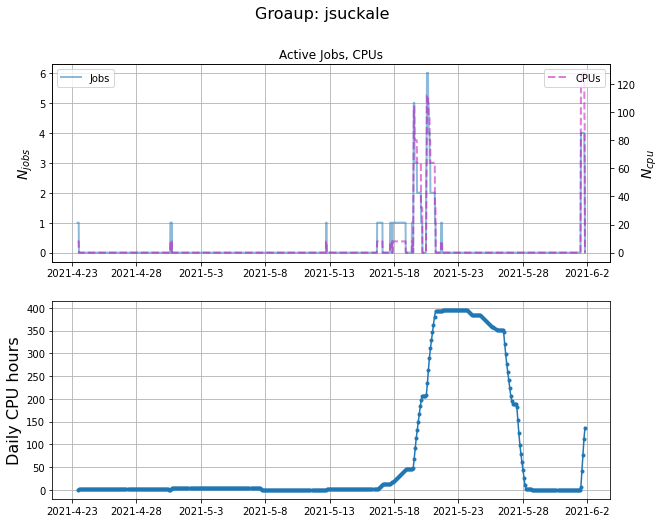

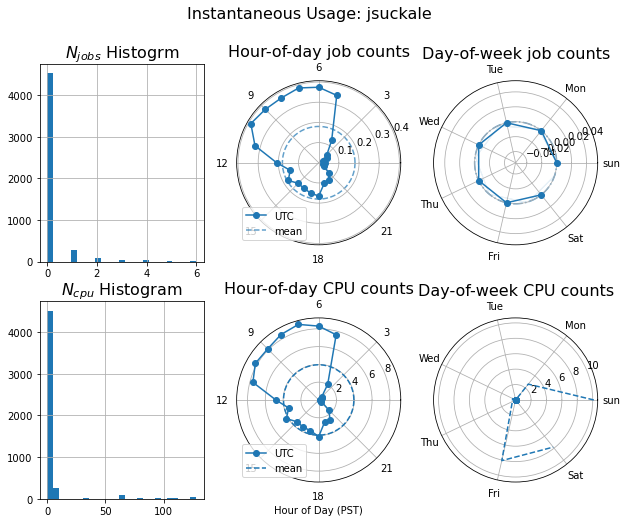

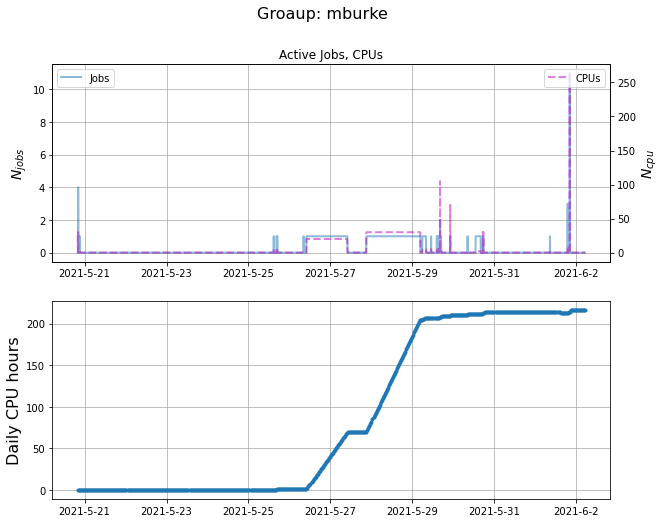

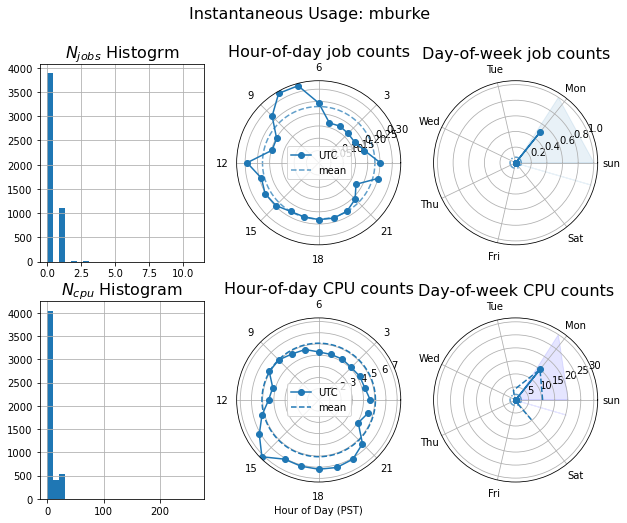

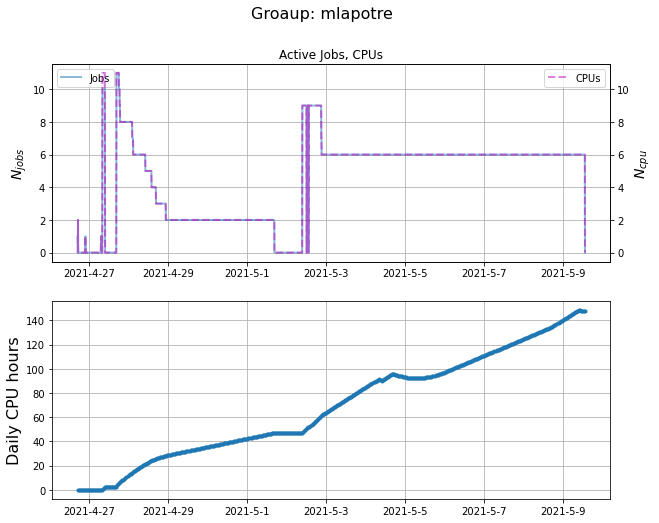

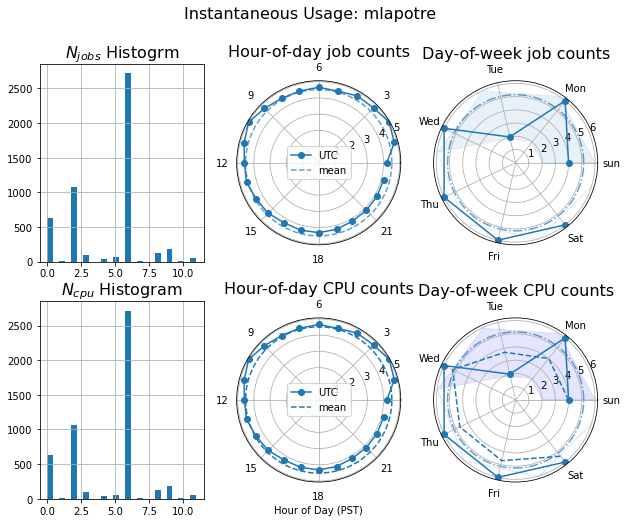

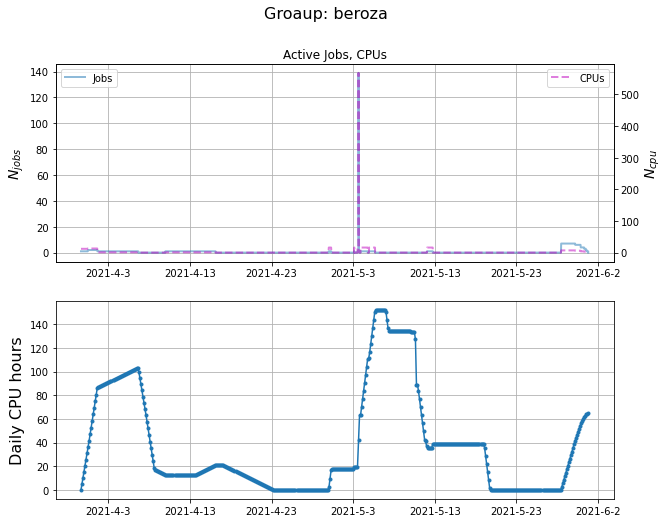

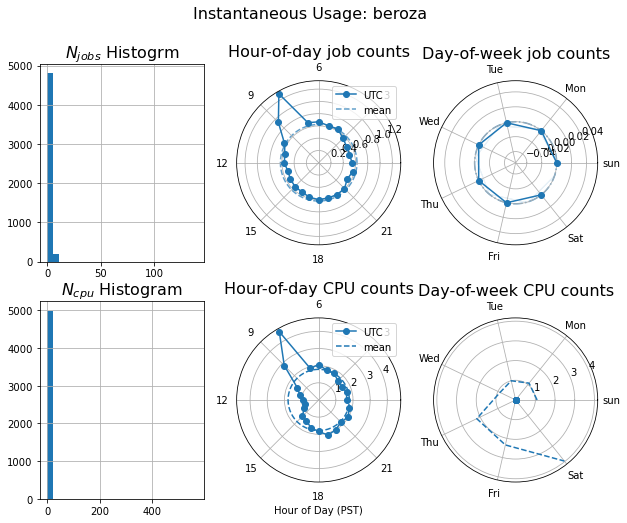

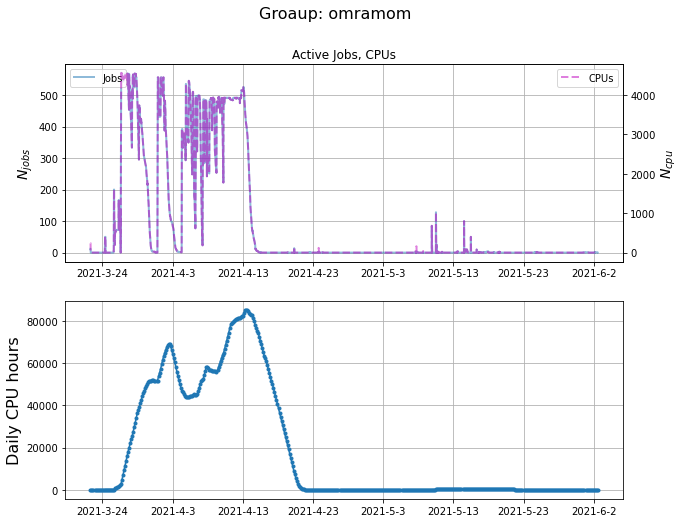

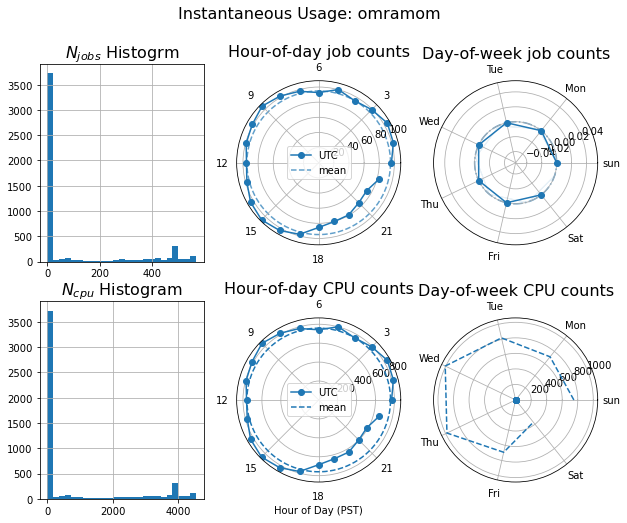

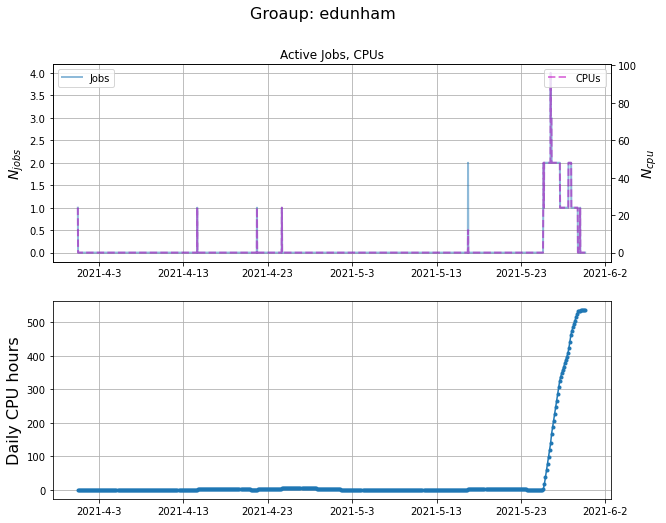

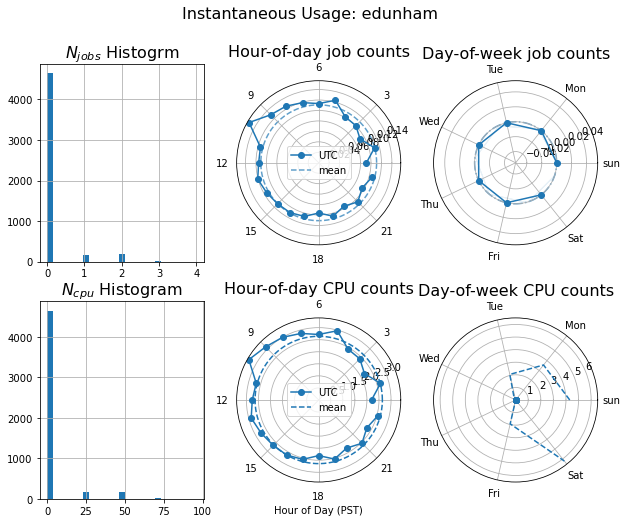

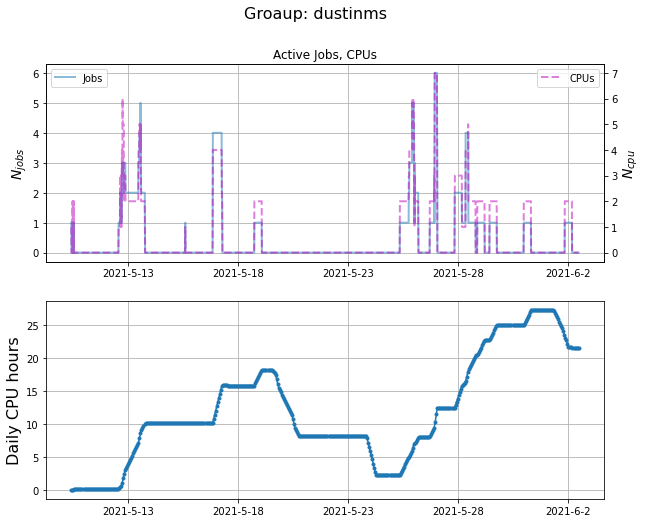

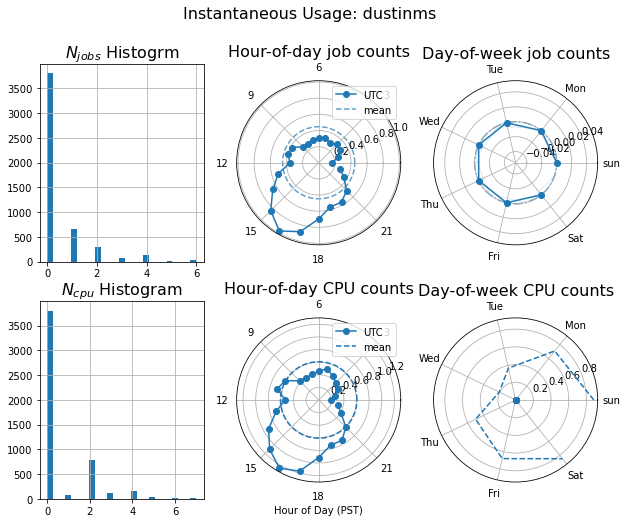

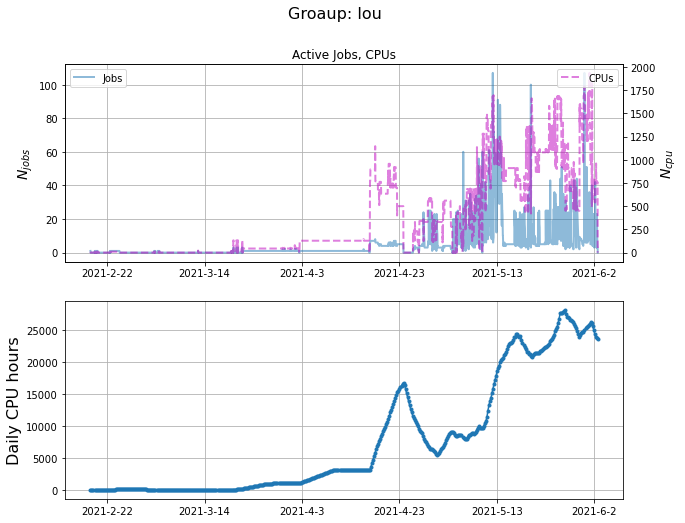

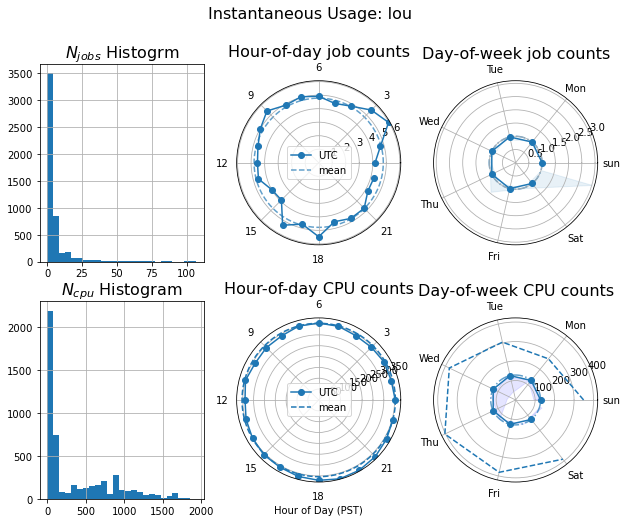

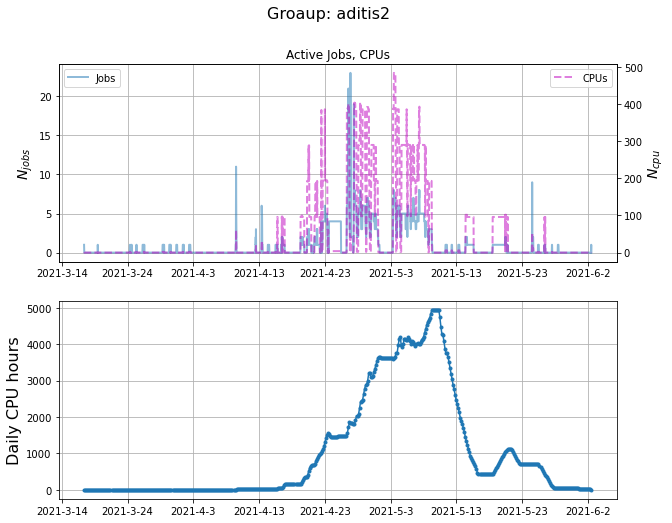

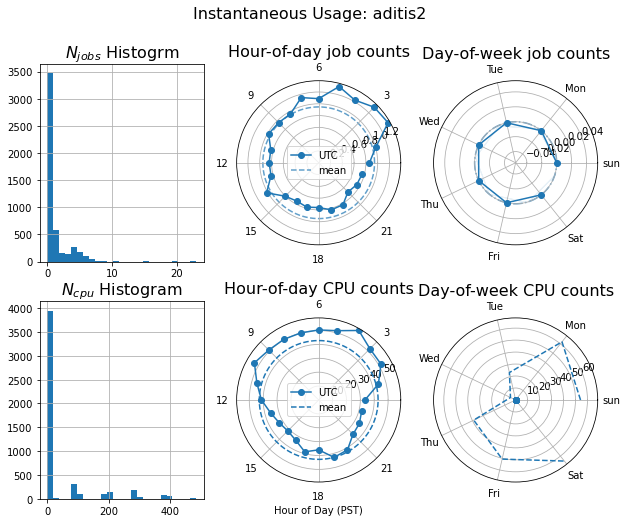

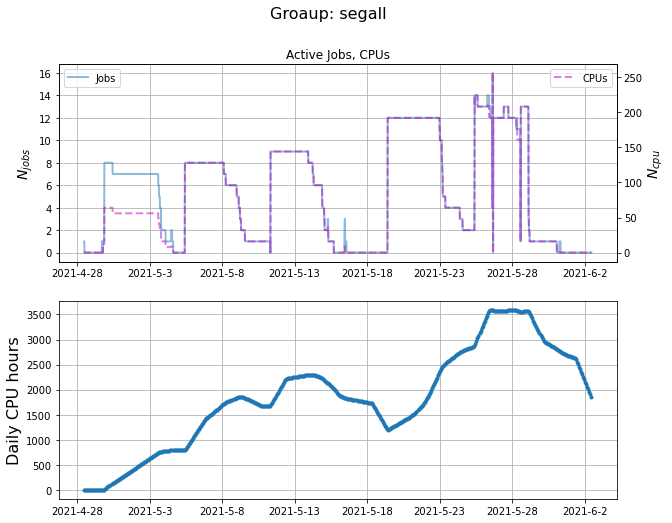

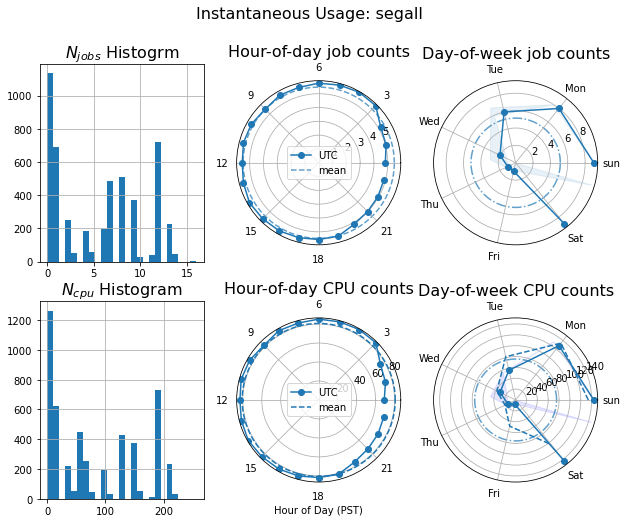

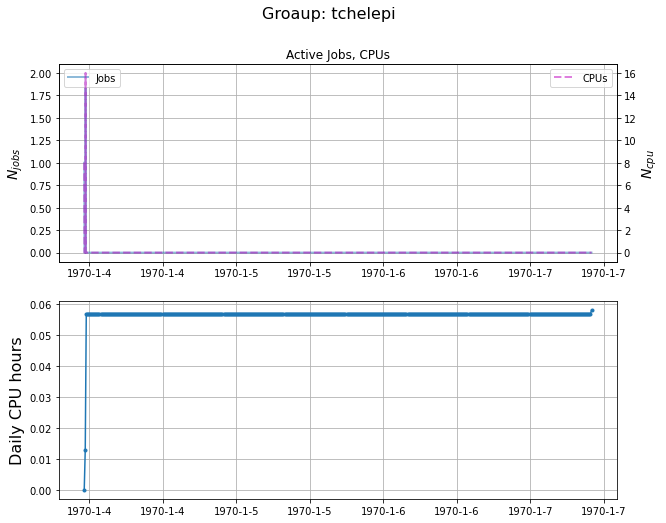

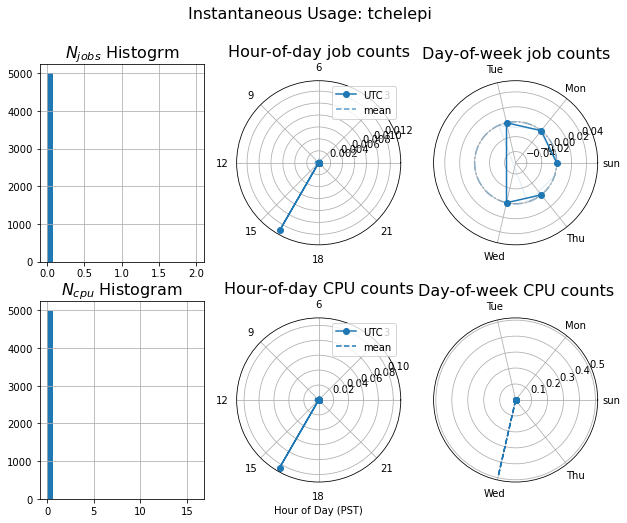

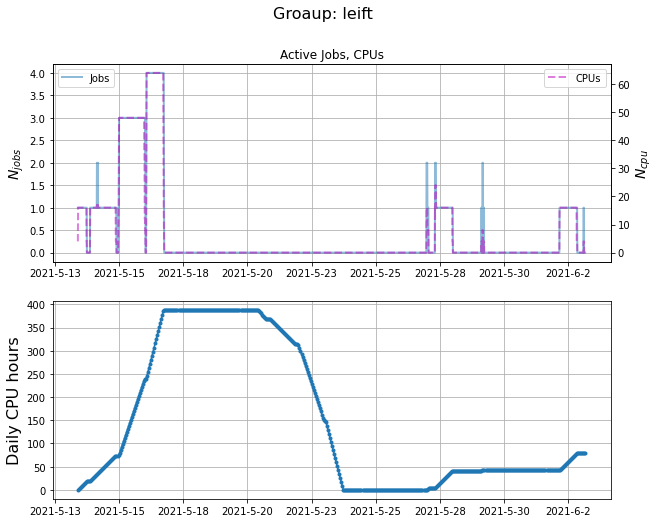

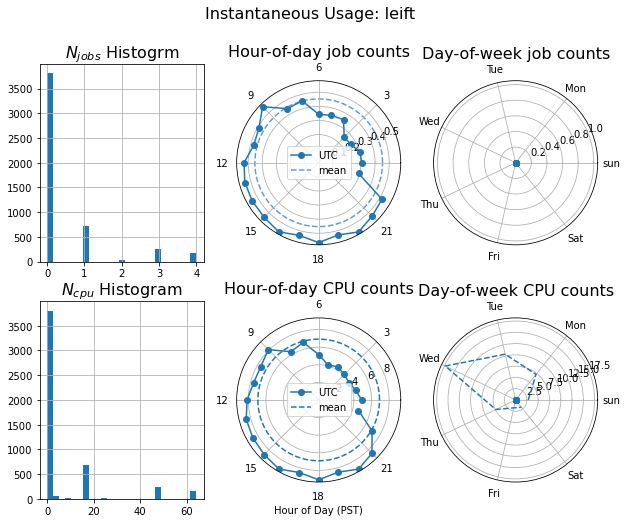

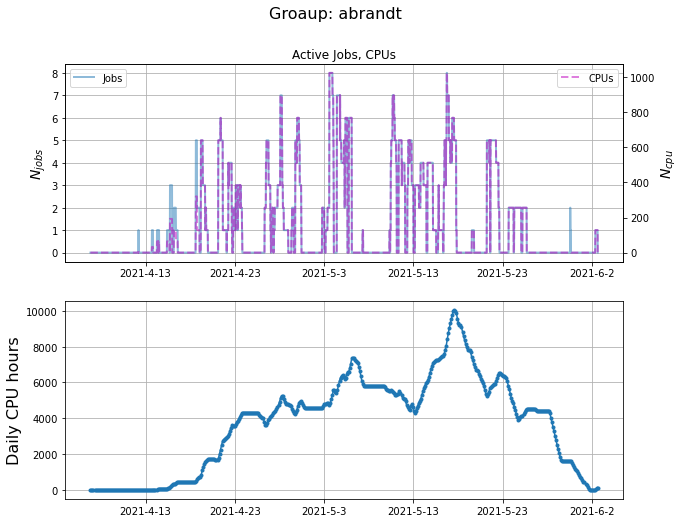

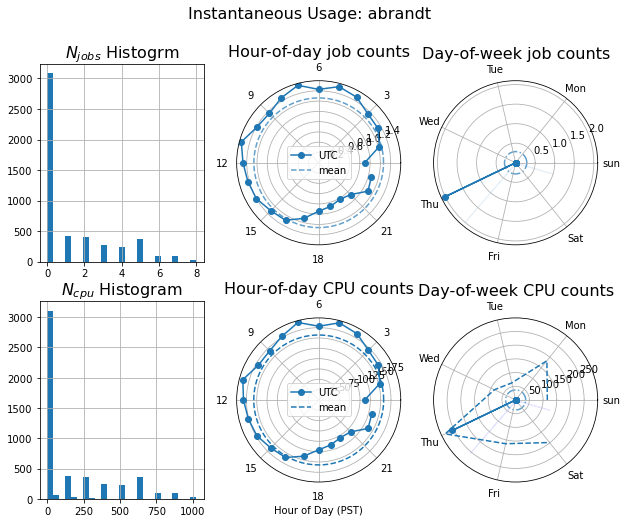

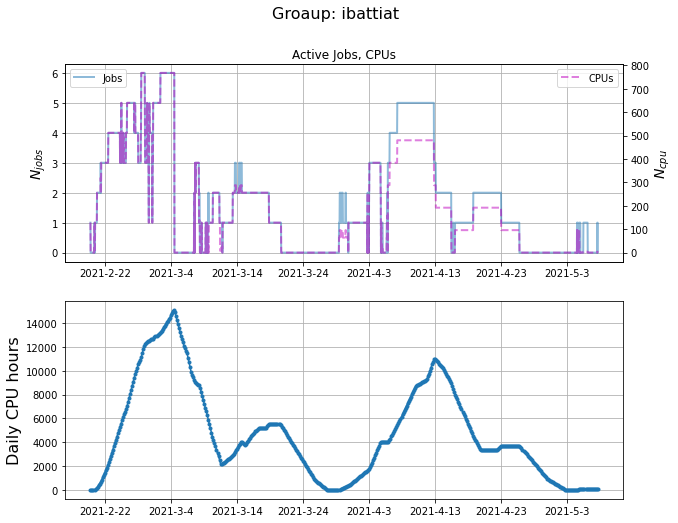

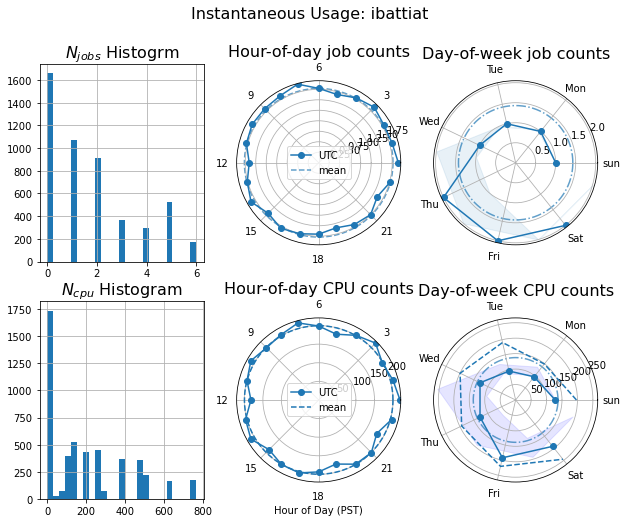

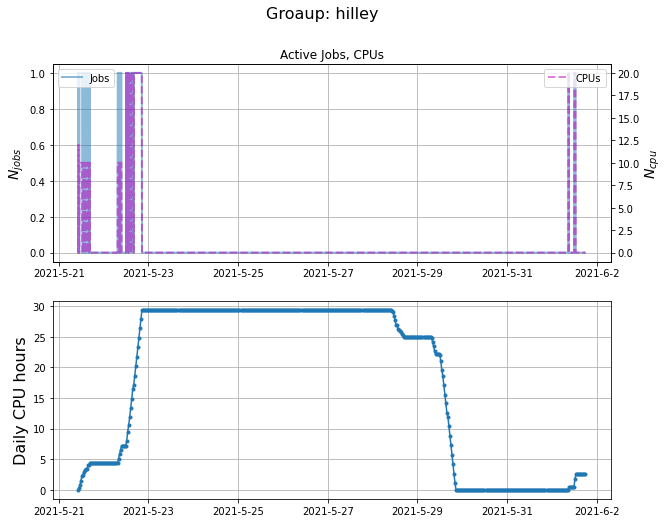

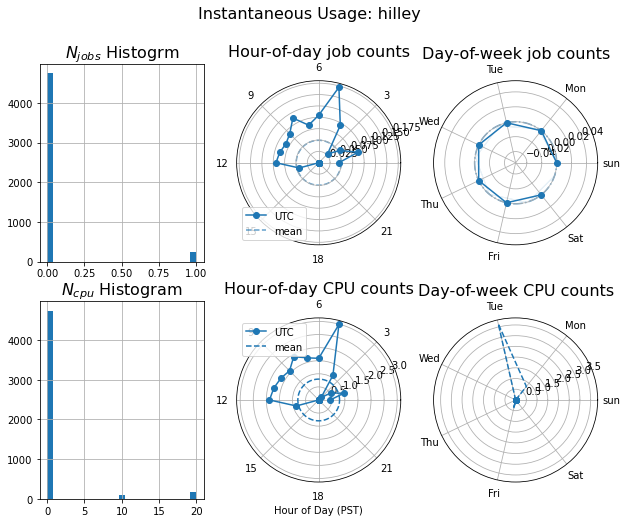

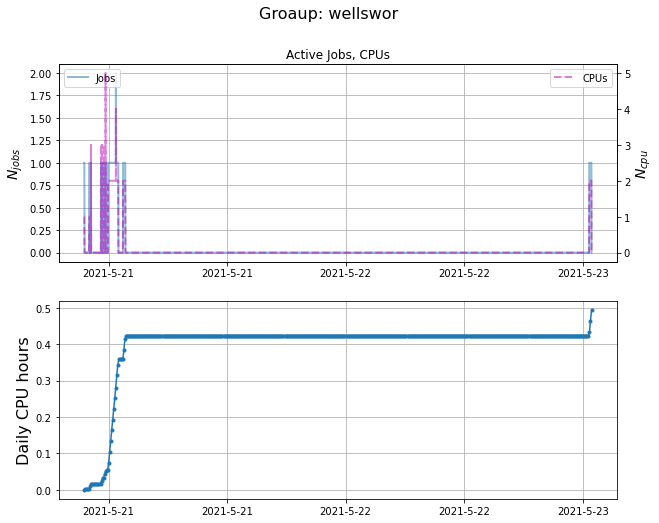

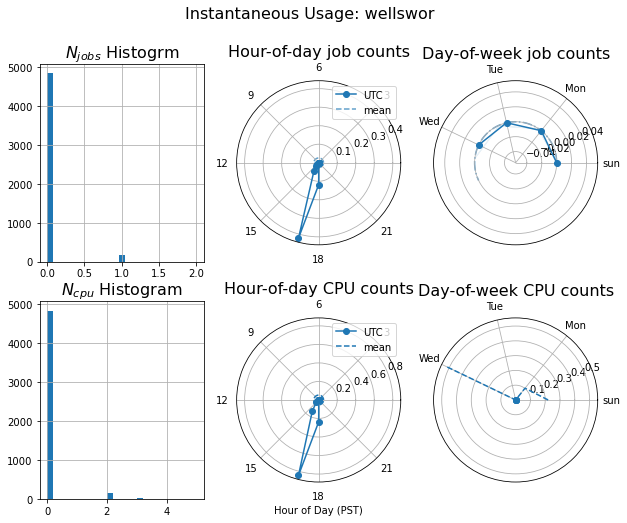

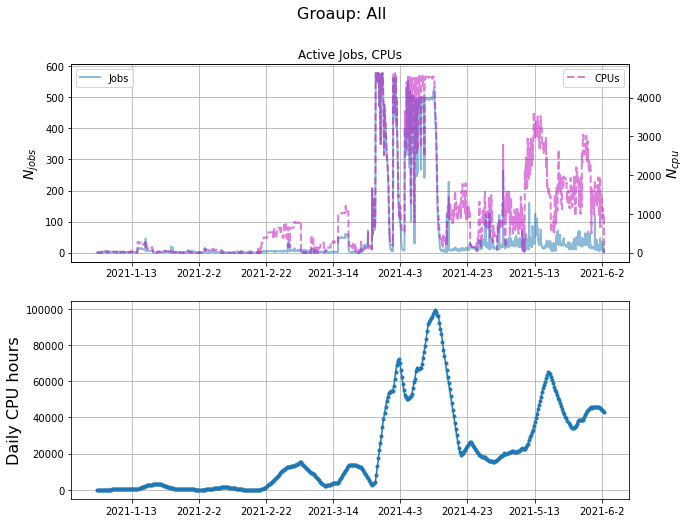

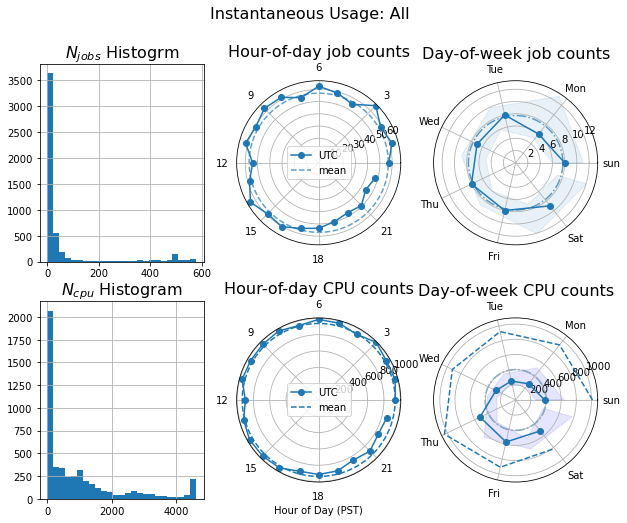

In [5]:
PI_groups = hpc_lib.get_PI_groups_from_groups(groups='sh_s-ees')
#
for ky,vl in PI_groups.items():
    print('** {}, {}'.format(ky,vl))
    #
#
SACCT = hpc_lib.SACCT_data_direct(partition='serc', start_date='2021-01-01', end_date='2021-06-03',
                                  keep_raw_data=False)
#
rpt = hpc_lib.SACCT_groups_analyzer_report(Short_title='SERC HPC Analytics', 
                Full_title='HPC Analytics Breakdown for Stanford Earth, Sherlock SERC',
                out_path='output/SERC_analytics_20210602', tex_filename='SERC_HPC_analytics.tex',
                                           groups=PI_groups, SACCT_obj=SACCT)
